In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from geopy.distance import great_circle

Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

In [14]:
data = pd.read_csv('taxi.csv')
data.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


### Датасет состоит из 100 000 предложений, null пропусков, но в датасете есть значения -1, их можно принять за пропуски.

### Можно предположить, что для одного заказа может быть несколько офферов.

In [17]:
data = data.drop(['offer_gk', 'order_gk'], axis=1)

In [18]:
data.describe()

,weekday_key,hour_key,driver_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.159860,13.827790,3446.376360,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,2.054222,7.306496,2038.738677,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,0.000000,0.000000,14.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,1.000000,8.000000,1421.000000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,3.000000,16.000000,3506.500000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,5.000000,20.000000,5242.000000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,6.000000,23.000000,6806.000000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


### Из таблицы видим, что геолокация может отсутствовать и для водителя, и для места заказа. Кто-то пытался объехать полмира, такие выбросы мы удаляем.

In [19]:
data.mode()

,weekday_key,hour_key,driver_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,5,23,1421,55.961859,37.407126,55.962322,37.407117,-1.0,-1.0,Economy,private,0


### Чаще всего люди заказывают такси эконом класса в пятницу вечером.

### Посмотрим на пропуски

In [20]:
data.replace(-1, np.nan).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
driver_latitude           99860 non-null float64
driver_longitude          99860 non-null float64
origin_order_latitude     99987 non-null float64
origin_order_longitude    99987 non-null float64
distance_km               73793 non-null float64
duration_min              73793 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(4), object(2)
memory usage: 9.2+ MB


### Есть несколько пропусков среди геоданных, и большое количество в расстоянии, и продолжительности поездки. Подчистим данные, убрав пропуски в геоданных.

In [21]:
data = data.replace(-1, np.nan).dropna(subset=['driver_latitude','driver_longitude','origin_order_latitude','origin_order_longitude'])

#Вернем обратно -1 для RandomForest
data = data.replace(np.nan,-1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99847 entries, 0 to 99999
Data columns (total 12 columns):
weekday_key               99847 non-null int64
hour_key                  99847 non-null int64
driver_gk                 99847 non-null int64
driver_latitude           99847 non-null float64
driver_longitude          99847 non-null float64
origin_order_latitude     99847 non-null float64
origin_order_longitude    99847 non-null float64
distance_km               99847 non-null float64
duration_min              99847 non-null float64
offer_class_group         99847 non-null object
ride_type_desc            99847 non-null object
driver_response           99847 non-null int64
dtypes: float64(6), int64(4), object(2)
memory usage: 9.9+ MB


### Уберем выбросы.

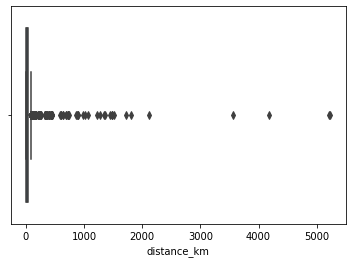

In [22]:
sns.boxplot(data['distance_km'])

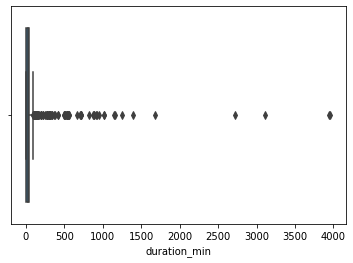

In [23]:
sns.boxplot(data['duration_min'])

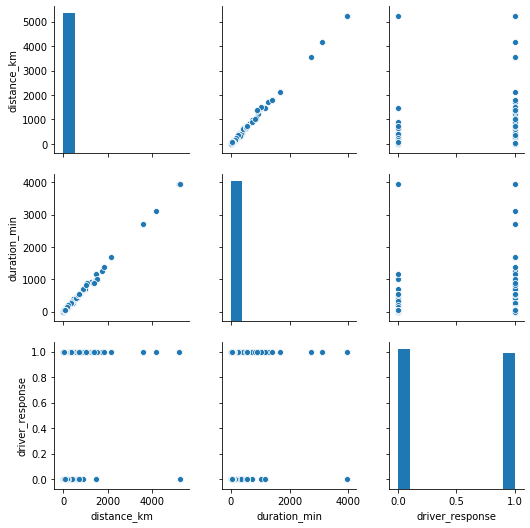

In [25]:
sns.pairplot(data,vars=['distance_km', 'duration_min', 'driver_response'])

### Теперь вычислим расстояние от водителя до клиента.

In [26]:
data['client_distance'] = data.apply(
    lambda row: great_circle(
        (row['driver_latitude'], row['driver_longitude']),
        (row['origin_order_latitude'], row['origin_order_longitude'])).km,
    axis=1)

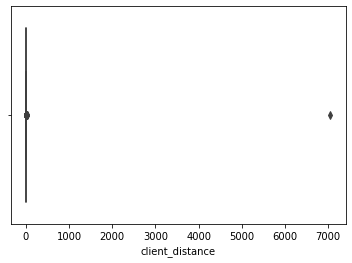

In [13]:
sns.boxplot(data['client_distance'])

In [27]:
data[ data['client_distance'] > 7000]

,weekday_key,hour_key,driver_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,client_distance
55260,0,14,771,0.0,0.0,55.410307,37.902451,43.726,55.45,Economy,private,0,7048.445771


### Это ошибка из-за геолокации водителя, уберем это значение.

In [28]:
data = data[ data['client_distance'] < 7000 ]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99846 entries, 0 to 99999
Data columns (total 13 columns):
weekday_key               99846 non-null int64
hour_key                  99846 non-null int64
driver_gk                 99846 non-null int64
driver_latitude           99846 non-null float64
driver_longitude          99846 non-null float64
origin_order_latitude     99846 non-null float64
origin_order_longitude    99846 non-null float64
distance_km               99846 non-null float64
duration_min              99846 non-null float64
offer_class_group         99846 non-null object
ride_type_desc            99846 non-null object
driver_response           99846 non-null int64
client_distance           99846 non-null float64
dtypes: float64(7), int64(4), object(2)
memory usage: 10.7+ MB


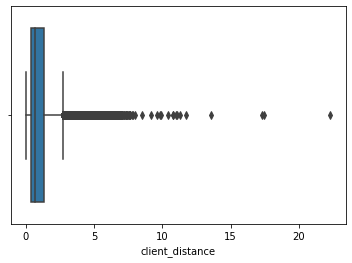

In [29]:
sns.boxplot(data['client_distance'])

### Создадим признак Выходной день.

In [30]:
data['is_weekend'] = data['weekday_key'].isin([0, 6]).astype(int)

C:\Users\rus17\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Добавим признак времени суток.

In [31]:
data['daytime'] = (data['hour_key'] > 5) & (data['hour_key'] < 22)
data['daytime'] = data['daytime'].astype(int)

C:\Users\rus17\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\rus17\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Преобразуем категориальные данные.

In [32]:
data.head()

,weekday_key,hour_key,driver_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,client_distance,is_weekend,daytime
0,5,20,6080,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0,1.363047,0,1
1,5,14,6080,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1,3.413097,0,1
2,6,14,6080,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0,0.410000,1,1
3,2,6,6080,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1,0.647473,0,1
4,4,16,6080,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1,1.062483,0,1


In [33]:
data['offer_class_group'].value_counts()

Economy     48317
Standard    47159
Premium      1770
Delivery     1286
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

### Уберем тестовые данные и объединим VIP и VIP+, чтобы сократить количество признаков для OHE.

In [34]:
data = data[ data['offer_class_group'] != 'Test']
data['offer_class_group'] = data['offer_class_group'].str.replace('VIP+', 'VIP', regex=False)
data['offer_class_group'].value_counts()

Economy     48317
Standard    47159
Premium      1770
Delivery     1286
Kids          588
XL            464
VIP           254
Name: offer_class_group, dtype: int64

In [35]:
data['ride_type_desc'].value_counts()

private      91183
business      8403
affiliate      224
SMB             28
Name: ride_type_desc, dtype: int64

In [36]:
data = pd.get_dummies(data, columns=['offer_class_group'])
data = pd.get_dummies(data, columns=['ride_type_desc'])
data

,weekday_key,hour_key,driver_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response,...,offer_class_group_Economy,offer_class_group_Kids,offer_class_group_Premium,offer_class_group_Standard,offer_class_group_VIP,offer_class_group_XL,ride_type_desc_SMB,ride_type_desc_affiliate,ride_type_desc_business,ride_type_desc_private
0,5,20,6080,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,0,...,1,0,0,0,0,0,0,0,0,1
1,5,14,6080,55.805342,37.515023,55.819329,37.466398,18.802,25.217,1,...,0,0,0,1,0,0,0,0,0,1
2,6,14,6080,55.813978,37.347688,55.814827,37.354074,6.747,9.800,0,...,1,0,0,0,0,0,0,0,0,1
3,2,6,6080,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,1,...,1,0,0,0,0,0,0,0,0,1
4,4,16,6080,55.803578,37.521602,55.812559,37.527407,12.383,19.250,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,2,2442,55.961246,37.413497,55.966694,37.415754,17.378,29.817,0,...,1,0,0,0,0,0,0,0,0,1
99996,0,1,2442,55.961246,37.413497,55.964892,37.413543,7.751,12.683,0,...,1,0,0,0,0,0,0,0,0,1
99997,1,20,2442,55.961315,37.413497,55.962203,37.416373,46.983,46.217,0,...,0,0,0,1,0,0,0,0,0,1
99998,6,21,2442,55.961354,37.413864,55.964892,37.413543,50.029,51.100,0,...,1,0,0,0,0,0,0,0,0,1


In [37]:
clean_data = data.drop(columns=['driver_gk','driver_latitude','driver_longitude','origin_order_latitude','origin_order_longitude'])
clean_data.head()

,weekday_key,hour_key,distance_km,duration_min,driver_response,client_distance,is_weekend,daytime,offer_class_group_Delivery,offer_class_group_Economy,offer_class_group_Kids,offer_class_group_Premium,offer_class_group_Standard,offer_class_group_VIP,offer_class_group_XL,ride_type_desc_SMB,ride_type_desc_affiliate,ride_type_desc_business,ride_type_desc_private
0,5,20,-1.000,-1.000,0,1.363047,0,1,0,1,0,0,0,0,0,0,0,0,1
1,5,14,18.802,25.217,1,3.413097,0,1,0,0,0,0,1,0,0,0,0,0,1
2,6,14,6.747,9.800,0,0.410000,1,1,0,1,0,0,0,0,0,0,0,0,1
3,2,6,-1.000,-1.000,1,0.647473,0,1,0,1,0,0,0,0,0,0,0,0,1
4,4,16,12.383,19.250,1,1.062483,0,1,0,1,0,0,0,0,0,0,0,0,1


### Делим готовую выборку.

In [38]:
X = clean_data.drop(columns='driver_response')
y = clean_data['driver_response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=16)

### Применим Случайный лес с базовыми параметрами, чтобы понять, что делать дальше.

In [39]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\rus17\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71     10278
           1       0.69      0.65      0.67      9690

    accuracy                           0.69     19968
   macro avg       0.69      0.69      0.69     19968
weighted avg       0.69      0.69      0.69     19968



### Результаты не правдоподобны, но, что есть, то есть.